# The Algorithm from *Trajectory Recovery from Ash: User Privacy is NOT Preserved in Aggregated Mobility Data* by Xu et al. (2017)

This notebook provides an explanation and implementation of the algorithm presented in the aforementioned research paper by F. Xu, Z. Tu, Y. Li, P. Zhang, X. Fu, and D. Jin. We evaluate the algorithm on two preprocessed open-source datasets: GeoLife and Porto Taxi.

## 1 Preliminaries

This section imports all dependencies and defines functions as required. The functions are direct implementations of the formulae described in Xu et. al's paper.

### 1.1 Dependencies

Set the `PATH` to the directory containing the data. It is assumed to contain two folders each for the two datasets used. Throughout the notebook, change file paths as necessary.

In [ ]:
PATH = "./data"

import os
import ast
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

###  1.2 Functions

In [2]:
def trajectory_entropy(trajectory):
    freq = {x:0 for x in trajectory}
    for x in trajectory:
        freq[x] += 1
    result = 0
    for f in [v for k, v in freq.items() if v > 0]:
        result -= (f/len(trajectory))*math.log2(f/len(trajectory))
    return result

def trajectory_gain(trajectory_1, trajectory_2):
    return trajectory_entropy(trajectory_1 + trajectory_2) - ((
                   trajectory_entropy(trajectory_1) +
                   trajectory_entropy(trajectory_2)
               ) / 2
           )

def preview_matrix(matrix, rows, cols):
    for i in range(rows):
        print(matrix[i][:cols])

def uniqueness(data, k):
    top_k_locs = [set() for _ in range(len(data))]
    for u in range(len(data)):
        freq = dict()
        for l in range(len(data[0])):
            if data[u][l] not in freq.keys():
                freq[data[u][l]] = 1
            else:
                freq[data[u][l]] += 1
        freq = sorted([(k, v) for k, v in freq.items()], key=lambda x: x[1], reverse=True)
        top_k_locs[u] = set([x[0] for x in freq][:k])
    return len(set(map(frozenset, top_k_locs))) / len(data)

## 2 The Algorithm, in Detailed Stages

In this section, we present the algorithm, as outlined in Xu et. al. (2017), step-by-step. We use an example dataset to demonstrate this.

### 2.1 Data Loading

We have a small dataset where 37 people are present at each time step, thus giving us 37 trajectories to reconstruct. There are 194 distinct locations. There are 5205 timesteps with a 2-minute interval between each one, meaning there are 720 steps per day. So for each day, indices $[0, 179]$ account for times 00:00 to 05:58, and indices $[180, 719]$ account for times 06:00 to 23:58. The dataset spans for about 7.23 days in total.

Throughout the code, $N$ refers to the number of users/trajectories in the dataset, $M$ is the number of locations, $T$ is the number of timesteps, and $D$ is the number of intervals in one day.

In [3]:
agg = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_aggregrated-37users-14x15.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_ground_truth-37users-14x15.csv"))
N = 37
M = 194
T = 5205
D = 720

We now need to get the data into the correct format:

- Input:
  - Aggregated dataset as a `pandas.DataFrame`, with $T$ rows and $M$ columns. Rows must appear in chronological order (i.e. by timestep). The order of columns (locations) from left to right will be used throughout the notebook. We require that the dataset begins at 00:00.
  - Location information as a `dict`. This should map the $i$, (where $i$ is the $i$-th location) to a tuple representing its real location in terms of **cartesian** lattitude/longitude coordinates.

- Truth:
  - A 2D ($N$ rows, $T$ columns) `list` or `np.array` of the true trajectories. The order of rows is not important, but each trajectory must contain the locations in chronological order. Each element is a **cartesian** lattitude/longitude tuple.
  - Note that this is **not** input into the algorithm, only used for evaluation.

In [4]:
# Get the data into the right format
agg = agg.drop("datetime", axis=1)
agg = agg.drop(agg.columns[(agg == 0).all()], axis=1)

reverse_grid = dict()
for i, name in enumerate(agg.columns):
    cell_id = ast.literal_eval(name)
    reverse_grid[cell_id] = {'i': i}

locations = truth_data[["cell_id", "tower"]].drop_duplicates()
for v in locations.T.to_dict().values():
    reverse_grid[ast.literal_eval(v['cell_id'])]['tower'] = ast.literal_eval(v['tower'])
grid = {v['i']: v['tower'] for k, v in reverse_grid.items()}

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("user")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])

We also need to set up some auxiliary data structures that are required for executing the algorithm:

- `locs` keeps track of which column in the cost matrix refers to what locations at each timestep (because this changes). It stores a `dict` for each timestep in a `list`.

- `pred` is an $N \times T$ list that will store the predicted trajectories. The first timestep for each day is filled in here as well.

In [5]:
locs = [dict() for _ in range(T)] # Records which column refers to what location at each timestep
pred = [[-1]*T for _ in range(N)] # Stores the predicted trajectories

for i in range(T):
    a = agg.iloc[[i]].values[0]
    tmp = 0
    for j, val in enumerate(a):
        for k in range(int(val)):
            locs[i][tmp+k] = j
            if i % D == 0: # insert starting points for each day
                pred[tmp+k][i] = j
        tmp += int(val)

### 2.2 Nighttime Trajectory Recovery

Recall that timesteps that are relevant to nighttime are 00:00 - 06:00. This is when $i \mod D < \lfloor D/4 \rfloor $, where $0 \le i < T$.

For these timesteps, we create a cost matrix and run the Linear Sum Assignment algorithm (an optimized version of the Hungarian Algorithm from the `scipy` library) to generate the next set of locations that minimize cost. The costs here are based on the geographical distance. A clearer construction of the cost matrix is shown diagramatically below:

Suppose for example that the aggregated dataset is as follows:

| Time | Loc. 1 | Loc. 2 | Loc. 3 |
| ---- | ------ | ------ | ------ |
| 1    | 3      | 2      | 1      |
| 2    | 2      | 1      | 3      |
| 3    | 2      | 0      | 4      |

We can obviously enumerate these people (and locations) and say that for the first timestep, we have the following:

| Traj. | Time 1 | Time 2 | Time 3 |
| ----- | ------ | ------ | ------ |
| **1** | 1      |        |        |
| **2** | 1      |        |        |
| **3** | 1      |        |        |
| **4** | 2      |        |        |
| **5** | 2      |        |        |
| **6** | 3      |        |        |

We need to work out who goes where next for the second timestep. The locations available are those available in the second timestep of the aggregated dataset. The cost of a user being in a particular location is given by the heuristics in *Xu et al.* (2017). The *cost* matrix for transitioning to timestep 2 is as follows:

| Traj. | Loc. 1 | Loc. 1 | Loc. 2 | Loc. 3 | Loc. 3 | Loc. 3 |
| ----- | ------ | ------ | ------ | ------ | ------ | ------ |
| **1** |cost(1,1)|cost(1,1)|cost(1,2)|cost(1,3)|cost(1,3)|cost(1,3)|
| **2** |cost(1,1)|cost(1,1)|cost(1,2)|cost(1,3)|cost(1,3)|cost(1,3)|
| **3** |cost(1,1)|cost(1,1)|cost(1,2)|cost(1,3)|cost(1,3)|cost(1,3)|
| **4** |cost(2,1)|cost(2,1)|cost(2,2)|cost(2,3)|cost(2,3)|cost(2,3)|
| **5** |cost(2,1)|cost(2,1)|cost(2,2)|cost(2,3)|cost(2,3)|cost(2,3)|
| **6** |cost(3,1)|cost(3,1)|cost(3,2)|cost(3,3)|cost(3,3)|cost(3,3)|

This generates an assignment of trajectories to locations, which we can add to our predictions:

| Traj. | Time 1 | Time 2 | Time 3 |
| ----- | ------ | ------ | ------ |
| **1** | 1      | 1      |        |
| **2** | 1      | 1      |        |
| **3** | 1      | 2      |        |
| **4** | 2      | 3      |        |
| **5** | 2      | 3      |        |
| **6** | 3      | 3      |        |

For the third timestep, the cost matrix columns relate to the locations available in the third timestep of the aggregated dataset.

| Traj. | Loc. 1 | Loc. 1 | Loc. 3 | Loc. 3 | Loc. 3 | Loc. 3 |
| ----- | ------ | ------ | ------ | ------ | ------ | ------ |
| 1 |cost(1,1)|cost(1,1)|cost(1,3)|cost(1,3)|cost(1,3)|cost(1,3)|
| 2 |cost(1,1)|cost(1,1)|cost(1,3)|cost(1,3)|cost(1,3)|cost(1,3)|
| 3 |cost(2,1)|cost(2,1)|cost(2,3)|cost(2,3)|cost(2,3)|cost(2,3)|
| 4 |cost(3,1)|cost(3,1)|cost(3,3)|cost(3,3)|cost(3,3)|cost(3,3)|
| 5 |cost(3,1)|cost(3,1)|cost(3,3)|cost(3,3)|cost(3,3)|cost(3,3)|
| 6 |cost(3,1)|cost(3,1)|cost(3,3)|cost(3,3)|cost(3,3)|cost(3,3)|

This generates an assignment of trajectories to locations, which we can add to our predictions:

| Traj. | Time 1 | Time 2 | Time 3 |
| ----- | ------ | ------ | ------ |
| **1** | 1      | 1      | 1      |
| **2** | 1      | 1      | 1      |
| **3** | 1      | 2      | 3      |
| **4** | 2      | 3      | 3      |
| **5** | 2      | 3      | 3      |
| **6** | 3      | 3      | 3      |


In [6]:
for i in [x for x in range(T) if x % D < D // 4 and x + 1 < T]:
    if i % D == 0: print(f"Night {i//D} processing...")
    cost = np.zeros((N,N))
    for u in range(N): # users
        for l in range(N): # locations
            loc_i = grid[pred[u][i]]
            loc_j = grid[locs[i+1][l]]
            cost[u][l] = math.dist(loc_i, loc_j)
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    for u, l in zip(row_assn, col_assn):
        pred[u][i+1] = locs[i+1][l]

preview_matrix(pred, 5, D // 4)

Night 0 processing...
Night 1 processing...
Night 2 processing...
Night 3 processing...
Night 4 processing...
Night 5 processing...
Night 6 processing...
Night 7 processing...
[2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7]
[5, 5, 6, 6, 6, 6, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 

### 2.3 Daytime Trajectory Recovery

Recall that timesteps that are relevant to daytime are 06:00 - 24:00 (end of day). This is when $i \mod D \ge \lfloor D/4 \rfloor$, where $0 \le i < T$.

For these timesteps, we create a cost matrix and run the Linear Sum Assignment algorithm to generate the next set of locations that minimize cost. The costs here are based on geographical distance from the next estimated location. The next estimated location is provided by a velocity equation in Xu et. al.'s paper: "$l_i^{t+1} = q_i^t + (q_i^t - q_i^{t-1})$, where $l_i^{t+1}$ is the next estimated location for the $i$-th trajectory, and $q_i^t$ is the location at timestamp $t$ for the same trajectory."

In [7]:
for i in [x for x in range(T) if D // 4 <= x % D < D - 1]:
    if i % D == D // 4: print(f"Day {i // D} processing...")
    cost = np.zeros((N,N))
    for u in range(N): # users
        for l in range(N): # locations
            q_t = grid[pred[u][i]]
            q_t1 = grid[pred[u][i-1]]
            loc_i = (q_t[0]+(q_t[0]-q_t1[0]), q_t[1]+(q_t[1]-q_t1[1]))
            loc_j = grid[locs[i+1][l]]
            cost[u][l] = math.dist(loc_i, loc_j)
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    for u, l in zip(row_assn, col_assn):
        pred[u][i+1] = locs[i+1][l]

preview_matrix(pred, 5, D)

Day 0 processing...
Day 1 processing...
Day 2 processing...
Day 3 processing...
Day 4 processing...
Day 5 processing...
Day 6 processing...
[2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

### 2.4 Across Days Trajectory Recovery

We now have several ($T/D$) subtrajectories for $N$ people, each lasting 1 day. We cannot say that we have their full trajectories as we have not yet linked the end of one day (e.g. 23:59) to the start of the next day (00:00). We must link the $i$-th trajectory of one day to the $j$-th trajectory of the next day until with have complete trajectories.

We first "paginate" the predictions such that each page lasts for 1 day. For each day except the last, we fill in a cost matrix using the entropy and information gain formulations given by *Xu et al.* and run it again through the linear sum assignment algorithm. We record the linkage at each step.


In [8]:
for i in range(N):
    pred[i] = [pred[i][j:j+D] for j in range(0,T,D)]

days = [[x[i] for x in pred] for i in range(math.ceil(T/D))]
links = [None for _ in range(len(days)-1)]

for i in range(len(days)-1):
    print(f"Day {i} processing...")
    cost = np.zeros((N,N))
    for a in range(N): # trajectory i
        for b in range(N): # trajectory j
            cost[a][b] = trajectory_gain(days[i][a], days[i+1][b])
    row_assn, col_assn = scipy.optimize.linear_sum_assignment(cost, maximize=False)
    links[i] = col_assn

Day 0 processing...
Day 1 processing...
Day 2 processing...
Day 3 processing...
Day 4 processing...
Day 5 processing...
Day 6 processing...


We recover the full trajectories by traversing the linkages.

In [9]:
pred = [days[0][i] for i in range(N)]
for i in range(N): # users
    curr_row = i
    for j in range(len(days)-1): # days
        next_row = links[j][curr_row]
        pred[i] = pred[i] + days[j+1][next_row]
        curr_row = next_row

preview_matrix(pred, 1, T)

[2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

### 2.5 Evaluation

Recall that:
  - `truth` is a list of lists $[[1..T]..N]$ where each element is a cartesian lattitude/longitude tuple.
  - `pred` is a list of lists $[[1..T]..N]$ where each element contains a location-ID (that can be mapped back to the location tuple using `grid`).

---

We now must associate a predicted trajectory to a true trajectory - we do so by pairing trajectories that have the least recovery error. Each trajectory must be uniquely linked, so the linear sum assignment algorithm is run once again to link trajectories with the least recovery error. The `compare` list records the associations as: `compare[i] = j` means that the $i$-th predicted trajectory is associated with the $j$-th true trajectory.


The three metrics in the paper are:
  - Accuracy: The ratio of points that are correct.
  - Recovery Error: The euclidean distance of error.
  - Uniqueness: Percentage of trajectories that can be uniquely distinguished by their most frequent $k$ locations. We mirror the paper and restrict $k$ to be $1 \le k \le 5$. (It is noted that commonly, $k=2$).

In [10]:
accuracy = 0
recovery_error = 0

accuracy_matrix = np.zeros((N,N))
error_matrix = np.zeros((N,N))

for i in range(N): # predicted trajectories
    print(f"Evaluating trajectory {i}...")
    for j in range(N): # truth trajectories
        error = 0
        acc = 0
        for k in range(T): # timesteps
            pred_loc = grid[pred[i][k]]
            x = math.dist(pred_loc, truth[j][k])
            error += x # location error
            if x == 0: # accuracy
                acc += 1
        error_matrix[i][j] = error
        accuracy_matrix[i][j] = acc / T

# here, compare[i] = j means the i-th predicted trajectory matches the j-th true trajectory.
pred_traj, true_traj = scipy.optimize.linear_sum_assignment(error_matrix, maximize=False)
for i, j in zip(pred_traj, true_traj):
    accuracy += accuracy_matrix[i][j] / N
    recovery_error += error_matrix[i][j]

print(f"Accuracy: {accuracy}")
print(f"Recovery Error: {recovery_error}")
for i in range(1,6):
    print(f"Uniqueness (k={i}), Predicted: {uniqueness(pred, i)}")
    print(f"Uniqueness (k={i}), Truth: {uniqueness(truth, i)}")
print(true_traj)

Evaluating trajectory 0...
Evaluating trajectory 1...
Evaluating trajectory 2...
Evaluating trajectory 3...
Evaluating trajectory 4...
Evaluating trajectory 5...
Evaluating trajectory 6...
Evaluating trajectory 7...
Evaluating trajectory 8...
Evaluating trajectory 9...
Evaluating trajectory 10...
Evaluating trajectory 11...
Evaluating trajectory 12...
Evaluating trajectory 13...
Evaluating trajectory 14...
Evaluating trajectory 15...
Evaluating trajectory 16...
Evaluating trajectory 17...
Evaluating trajectory 18...
Evaluating trajectory 19...
Evaluating trajectory 20...
Evaluating trajectory 21...
Evaluating trajectory 22...
Evaluating trajectory 23...
Evaluating trajectory 24...
Evaluating trajectory 25...
Evaluating trajectory 26...
Evaluating trajectory 27...
Evaluating trajectory 28...
Evaluating trajectory 29...
Evaluating trajectory 30...
Evaluating trajectory 31...
Evaluating trajectory 32...
Evaluating trajectory 33...
Evaluating trajectory 34...
Evaluating trajectory 35...
Ev

### 2.6 Visualisation

The following cell allows us to visualise and compare the recovered trajectories to their associated true trajectories. You may change the `trajectory_choice` and `length_choice` variables to any value within $[0, N)$ and $[0, T)$ respectively to show specific results.

Note that a blank plot indicates that the user did not move at all in the trajectory.

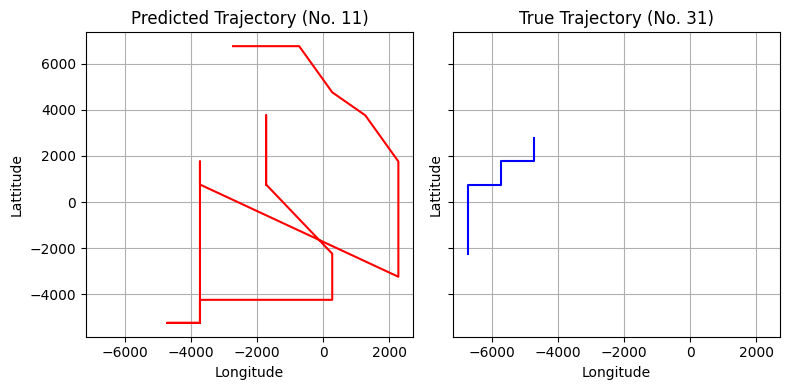

In [11]:
import random

trajectory_choice = random.randint(0,N-1)
length_choice = D

pred_line = pred[trajectory_choice][:length_choice]
pred_line = [grid[x] for x in pred_line]
true_line = truth[true_traj[trajectory_choice]][:length_choice]

x1, y1 = zip(*pred_line)
x2, y2 = zip(*true_line)
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axs[0].plot(x1, y1, color='red')
axs[0].set_title(f'Predicted Trajectory (No. {trajectory_choice})')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Lattitude')
axs[0].grid()

axs[1].plot(x2, y2, color='blue')
axs[1].set_title(f'True Trajectory (No. {true_traj[trajectory_choice]})')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Lattitude')
axs[1].grid()

plt.tight_layout()
plt.show()

## 3 Example Usage and Evaluation on Other Datasets

### 3.1 The Class

The above has been refined and restructured into a class for ease of use. The class constructor accepts correctly-formatted datasets (as described in Section 2.1), which can then be fed into the algorithm for evaluating. Some example usage is shown in this section. The dependencies outside of the Python standard library are: `numpy`, `pandas`, `matplotlib`, `scipy`, `geopy`, and `tqdm`.

In [12]:
from trajectory_recovery import TrajectoryRecovery

### 3.2 GeoLife Dataset

GeoLife is a human mobility dataset containing people's trajectories over spans of time. Data preprocessing was tricky due to the irregularity and sparsity of the dataset, but nevertheless we arrived at 3 different options for use as a dataset:

Option 1 (this was used in the walkthrough earlier in the notebook):
  - 37 trajectories
  - 194 locations
  - 5205 timesteps
  - 2-minute time interval
  - About 7.23 days overall duration

Option 2:
  - 38 trajectories
  - 492 locations
  - 10407 timesteps
  - 1-minute time interval
  - About 7.23 days overall duration

Option 3:
  - 43 trajectories
  - 120 locations
  - 10103 timesteps
  - 1-minute time interval
  - About 7.02 days overall duration

In [13]:
# 37 User dataset
"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_aggregrated-37users-14x15.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_ground_truth-37users-14x15.csv"))
N = 37
M = 194
T = 5205
D = 720
"""

# 38 User Dataset
#"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_aggregrated-38u-3m-35x29-60s.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_ground_truth-38u-3m-35x29-60s.csv"))
N = 38
M = 492
T = 10407
D = 1440
#"""

# 43 User dataset
"""
agg = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_aggregrated-43u-5m-11x11-60s.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "GeoLife/processed/GeoLife_ground_truth-43u-5m-11x11-60s.csv"))
N = 43
M = 120
T = 10103
D = 1440
"""

# Get the data into the right format
agg = agg.drop("datetime", axis=1)
agg = agg.drop(agg.columns[(agg == 0).all()], axis=1)

reverse_grid = dict()
for i, name in enumerate(agg.columns):
    cell_id = ast.literal_eval(name)
    reverse_grid[cell_id] = {'i': i}

locations = truth_data[["cell_id", "tower"]].drop_duplicates()
for v in locations.T.to_dict().values():
    reverse_grid[ast.literal_eval(v['cell_id'])]['tower'] = ast.literal_eval(v['tower'])
grid = {v['i']: v['tower'] for k, v in reverse_grid.items()}

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("user")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])


geo_life = TrajectoryRecovery(agg, grid, N, M, T, D)
geo_life.run_algorithm()
geo_life.evaluate(truth)
geo_life.get_results()

Evaluating Trajectories: 100%|███████████████████████████████████| 38/38 [00:03<00:00, 10.92traj./s]


{'accuracy': 0.4132896380472657,
 'recovery_error': 753602966.4598236,
 'uniqueness': {'predicted': {1: 0.5789473684210527,
   2: 0.868421052631579,
   3: 0.9473684210526315,
   4: 1.0,
   5: 1.0},
  'truth': {1: 0.6052631578947368,
   2: 0.7894736842105263,
   3: 0.868421052631579,
   4: 0.9210526315789473,
   5: 1.0}},
 'compare': [(0, 10),
  (1, 20),
  (2, 18),
  (3, 26),
  (4, 22),
  (5, 34),
  (6, 37),
  (7, 28),
  (8, 25),
  (9, 19),
  (10, 1),
  (11, 0),
  (12, 32),
  (13, 29),
  (14, 21),
  (15, 33),
  (16, 5),
  (17, 27),
  (18, 8),
  (19, 15),
  (20, 11),
  (21, 35),
  (22, 3),
  (23, 2),
  (24, 31),
  (25, 13),
  (26, 16),
  (27, 6),
  (28, 12),
  (29, 23),
  (30, 36),
  (31, 7),
  (32, 24),
  (33, 17),
  (34, 4),
  (35, 9),
  (36, 30),
  (37, 14)]}

### 3.3 Porto Taxi Dataset

Porto Taxi is a taxi dataset containing the trajectories of taxis in the city of Porto, Portugal. We expect the algorithm to perform less accurately here, because this is no longer human mobility, but vehicular. We have two different subsets of the Porto Taxi dataset, each of which we can evaluate separately on the algorithm.

Option 1 places discrete locations in a $3 \times 3$ grid, creating 9 locations:
- 197 trajectories
- 9 locations
- 4321 timesteps
- 10-minute time interval
- 30 days overall duration

Option 2 places locations on a $7 \times 7$ grid (the diameter of each cell is still the same as the first option), creating 49 locations:
- 197 trajectories
- 49 locations
- 4321 timesteps
- 10-minute time interval
- 30 days overall duration

In [14]:
# 3x3 version
"""
agg = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/Porto taxi aggregated 3x3.csv"))
grid = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/Porto taxi grid 3x3.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/ground_truth 3x3.csv"))
N = 197 # number of users
M = 9 # number of locations
T = 4321 # number of timesteps
D = 144 # number of intervals in one day
"""
#"""
# 7x7 version
agg = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/Porto taxi aggregated 7x7.csv"))
grid = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/Porto taxi grid 7x7.csv"))
truth_data = pd.read_csv(os.path.join(PATH, "Porto Taxi/processed/ground_truth 7x7.csv"))
N = 197
M = 49
T = 4321
D = 144
#"""

agg = agg.drop("datetime", axis=1)
grid = grid.drop(["index", "bottomleft", "topright"], axis=1)
grid = grid.T.to_dict()
for k, v in grid.items():
    grid[k] = ast.literal_eval(v["towerlocation"])

truth_data.reset_index(inplace=True)
truth_data["ordered_towers"] = truth_data.apply(lambda x: (x["index"], x["tower"]), axis=1)
truth = []
for trajectory in truth_data.groupby("TAXI_ID")["ordered_towers"].apply(list):
    tmp = sorted(trajectory, key=lambda x: x[0])
    truth.append([ast.literal_eval(x[1]) for x in tmp])

porto_taxi = TrajectoryRecovery(agg, grid, N, M, T, D)
porto_taxi.run_algorithm()
porto_taxi.evaluate(truth)
porto_taxi.get_results()

Evaluating Trajectories: 100%|█████████████████████████████████| 197/197 [00:36<00:00,  5.46traj./s]


{'accuracy': 0.2557431126701495,
 'recovery_error': 2328102.3138824995,
 'uniqueness': {'predicted': {1: 0.04060913705583756,
   2: 0.19289340101522842,
   3: 0.36548223350253806,
   4: 0.5126903553299492,
   5: 0.5685279187817259},
  'truth': {1: 0.04060913705583756,
   2: 0.1116751269035533,
   3: 0.14720812182741116,
   4: 0.19289340101522842,
   5: 0.20812182741116753}},
 'compare': [(0, 87),
  (1, 115),
  (2, 169),
  (3, 32),
  (4, 55),
  (5, 131),
  (6, 180),
  (7, 92),
  (8, 23),
  (9, 18),
  (10, 164),
  (11, 33),
  (12, 16),
  (13, 28),
  (14, 107),
  (15, 137),
  (16, 111),
  (17, 20),
  (18, 91),
  (19, 143),
  (20, 145),
  (21, 105),
  (22, 98),
  (23, 150),
  (24, 66),
  (25, 138),
  (26, 94),
  (27, 6),
  (28, 41),
  (29, 52),
  (30, 77),
  (31, 48),
  (32, 0),
  (33, 58),
  (34, 119),
  (35, 109),
  (36, 19),
  (37, 34),
  (38, 43),
  (39, 186),
  (40, 79),
  (41, 166),
  (42, 72),
  (43, 125),
  (44, 37),
  (45, 174),
  (46, 96),
  (47, 53),
  (48, 153),
  (49, 182),
  

# 4 References

1. F. Xu, Z. Tu, Y. Li, P. Zhang, X. Fu, and D. Jin, “Trajectory recovery from ash:
User privacy is not preserved in aggregated mobility data,” in Proceedings of the
26th International Conference on World Wide Web, ser. WWW ’17. International
World Wide Web Conferences Steering Committee, Apr. 2017. [Online]. Available:
http://dx.doi.org/10.1145/3038912.3052620

2. Y. Zheng, H. Fu, X. Xie, W.-Y. Ma, and Q. Li, Geolife GPS trajectory dataset - User Guide, geolife gps trajectories 1.1 ed., July 2011. [Online]. Available: https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/

3. M. O’Connell, L. Moreira-Matias, and W. Kan, “Ecml/pkdd 15: Taxi trajectory prediction (i),” 2015.  [Online]. Available: https://kaggle.com/competitions/pkdd-15-predict-taxi-service-trajectory-i
